<a href="https://colab.research.google.com/github/emojivibe/upskill_campus_files/blob/main/code/Forecasting_baseline_urvashi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow==2.10.1

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.initializers import he_normal
%matplotlib inline

# Display only top 5 and bottom 5 rows
pd.set_option('display.max_rows', 10)

In [4]:
# Set random seed for reproducibility
# Note: CuDNN is usually non-deterministic
# (can't determine which of the ~3000 threads finish earlier)
# And floating points reduction is not perfectly associative due to ULP rounding
import numpy as np
np.random.seed(1337)
import tensorflow as tf
tf.random.set_seed(1337)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path="/content/drive/MyDrive/upskill campus_files/train_mc.csv"
df_train = pd.read_csv(path, parse_dates=[0], infer_datetime_format=True)
df_train

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


#preprocessing

In [7]:
train = df_train.pivot(index='DateTime',columns='Junction', values='Vehicles')
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,NaN
2015-11-01 01:00:00,13.0,6.0,7.0,NaN
2015-11-01 02:00:00,10.0,5.0,5.0,NaN
2015-11-01 03:00:00,7.0,6.0,1.0,NaN
2015-11-01 04:00:00,9.0,7.0,2.0,NaN
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


#remove Nan(0 vehicle)

In [8]:
train = train.fillna(0)

#normalize the data on 0,1

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [10]:
# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))

In [11]:
train[train.columns] = scaler.fit_transform(train[train.columns])

In [12]:
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,0.066225,0.106383,0.044693,0.000000
2015-11-01 01:00:00,0.052980,0.106383,0.033520,0.000000
2015-11-01 02:00:00,0.033113,0.085106,0.022346,0.000000
2015-11-01 03:00:00,0.013245,0.106383,0.000000,0.000000
2015-11-01 04:00:00,0.026490,0.127660,0.005587,0.000000
...,...,...,...,...
2017-06-30 19:00:00,0.662252,0.702128,0.178771,0.305556
2017-06-30 20:00:00,0.602649,0.723404,0.167598,0.833333
2017-06-30 21:00:00,0.562914,0.638298,0.150838,0.444444


#generate rolling forecast features

In [13]:
nb_forecast_per_junction = 24 * (31 + 31 + 30 + 31) # Days in jul + aug + sep + oct

In [14]:
nb_forecast_per_junction

2952

In [15]:
nb_forecast_per_junction * 4

11808

In [16]:
num_feats = 4
seq_len = 24 * 2 # We predict 48 hours
num_outputs = 4
num_hidden = 4 # We keep 8 days of state
bs = 128
epochs = 500
LOG_PATH = "checkpoints/" + time.strftime("%Y-%m-%d_%H%M-")+"s2s-concat-Conv1d.hdf5"

# pred_len = int(nb_forecast_per_junction / seq_len)
# assert nb_forecast_per_junction % seq_len == 0 # Check that we can split forecast into even sequences
# print(pred_len)

In [17]:
def make_input_seqs(data, seq_len, train_split=0.9):
    seq_len = seq_len + 1
    result = []
    for index in range(len(data) - seq_len):
        result.append(data[index: index + seq_len, :])
    result = np.array(result) # shape (14423, 168, 4)
    train_ind = round(train_split * result.shape[0])
    train = result[:int(train_ind), :, :]
    x_train = train[:, :-1, :]
    y_train = train[:, -1, :]
    x_test = result[int(train_ind):, :-1, :]
    y_test = result[int(train_ind):, -1, :]

    return [x_train, y_train, x_test, y_test]

In [18]:
X_train, y_train, X_test, y_test = make_input_seqs(train.values, seq_len)

# Generate model

## Loss function

In [19]:
import keras.backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [20]:
pip install adam

In [21]:
print(adam)

NameError: ignored

#Neural net and Optimizer

In [22]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
adam = Adam(clipvalue=0.5) # Clip to avoid exploding gradients
rmsprop = RMSprop(lr = 0.005, decay = 0.05)
# sgd = sgd(lr = 0.005, decay = 0.05)

optim = adam

/usr/local/lib/python3.10/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [23]:
from keras.layers import *
from keras.layers.core import *
from keras.layers import *
from keras.models import *
from keras.activations import *

# Model

In [24]:
def attention_n_days_ago(inputs, days_ago):
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = days_ago * 24
    suffix = str(days_ago) +'_days'

    # We compute the attention over the seq_len
    a = Permute((2, 1),
                name='Attn_Permute1_' + suffix)(inputs)
    a = Dense(time_steps,
              activation='softmax',
              name='Attn_DenseClf_' + suffix)(a)

    # Now we convolute so that it average over the whole time window
    feats_depth = int(inputs.shape[2])
    avg = Lambda(lambda x: K.expand_dims(x, axis = 1),
                 name='Attn_Unsqueeze_' + suffix)(inputs)
    avg = SeparableConv2D(feats_depth, (1,1),
                          name='Attn_DepthConv_' + suffix)(avg)
    avg = Lambda(lambda x: K.squeeze(x, 1),
                 name='Attn_Squeeze_'+ str(days_ago) + '_days')(avg)


    a_probs = Permute((2, 1),
                      name='Attn_Permute1_' + suffix)(avg)
    # out = Multiply(name='Attn_mul_'+ suffix)([inputs, a_probs])
    out = Concatenate(name='Attn_cat_'+ suffix)([inputs, a_probs])
    return out

In [25]:
def Net(num_feats, seq_len, num_hidden, num_outputs):
    x = Input(shape=(seq_len, num_feats))

    # Encoder RNNs
    enc = CuDNNGRU(seq_len,
                   return_sequences=True,
                   stateful = False,
                   name = 'Encoder_RNN')(x)

    # Attention decoders (lag features)
    attention_0d = attention_n_days_ago(enc, 0)
    attention_1d = attention_n_days_ago(enc, 1)
    attention_2d = attention_n_days_ago(enc, 2)
    attention_4d = attention_n_days_ago(enc, 4)
    attention_1w = attention_n_days_ago(enc, 7)
    attention_2w = attention_n_days_ago(enc, 14)
    attention_1m = attention_n_days_ago(enc, 30)
    attention_2m = attention_n_days_ago(enc, 60)
    attention_1q = attention_n_days_ago(enc, 92)
    attention_6m = attention_n_days_ago(enc, 184)
    attention_3q = attention_n_days_ago(enc, 276)
    attention_1y = attention_n_days_ago(enc, 365)

    att = Concatenate(name='attns_cat', axis = 1)([attention_0d,
                                                   attention_1d,
                                                   attention_2d,
                                                   attention_4d,
                                                   attention_1w,
                                                   attention_2w,
                                                   attention_1m,
                                                   attention_2m,
                                                   attention_1q,
                                                   attention_6m,
                                                   attention_3q,
                                                   attention_1y])
    # How to merge? concat, mul, add, use Dense Layer or convolution ?

    att = Dense(seq_len, activation=None, name='Dense_merge_attns')(att)
    # att = Lambda(lambda x: softmax(x, axis = 1),
    #              name='Dense_merge_3D_softmax')(att) # Flatten along the concat axis

    # Decoder RNN
    dec = CuDNNGRU(num_hidden,
                   return_sequences=False,
                   stateful = False,
                   name='Decoder_RNN')(att)

    # Regressor
    # Note that Dense is automatically TimeDistributed in Keras 2
    out = Dense(num_outputs, activation=None,
                name = 'Classifier')(dec) # no activation for regression

    model = Model(inputs=x, outputs=out)

    model.compile(loss= root_mean_squared_error, optimizer = optim)
    return model

In [26]:
model = Net(num_feats, seq_len, num_hidden, num_outputs)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 4)]      0           []                               
                                                                                                  
 Encoder_RNN (CuDNNGRU)         (None, 48, 48)       7776        ['input_1[0][0]']                
                                                                                                  
 Attn_Unsqueeze_0_days (Lambda)  (None, 1, 48, 48)   0           ['Encoder_RNN[0][0]']            
                                                                                                  
 Attn_Unsqueeze_1_days (Lambda)  (None, 1, 48, 48)   0           ['Encoder_RNN[0][0]']            
                                                                                              

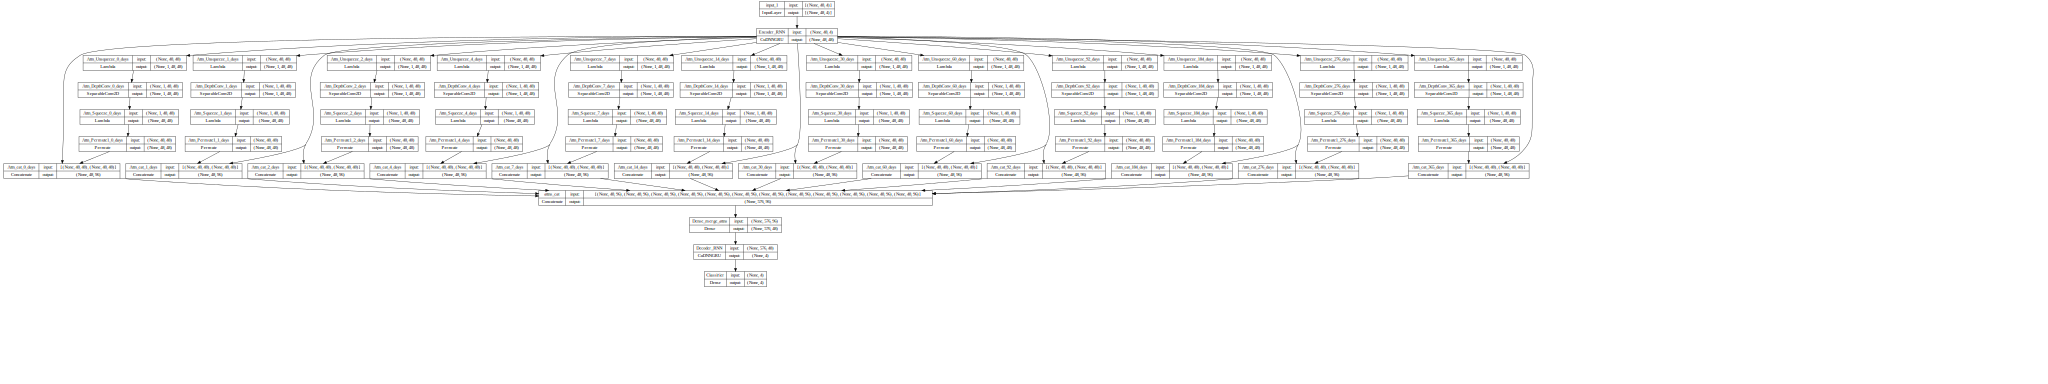

In [28]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

#Callbacks

In [29]:
from keras.callbacks import History, ModelCheckpoint, CSVLogger, EarlyStopping

In [30]:
history = History()
checkpointer = ModelCheckpoint(filepath= LOG_PATH,
                               verbose=1, save_best_only=False)
csv_logger = CSVLogger("checkpoints/" + time.strftime("%Y-%m-%d_%H%M-")+'training.log')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1,mode='auto')

#Training

In [31]:
print(X_train.shape)

(13089, 48, 4)


In [32]:
model.fit(X_train, y_train,
          batch_size=bs,
          epochs=epochs,
          validation_split=0.05,
          shuffle=False,
          callbacks=[history,checkpointer,csv_logger,early_stop])

Epoch 1/500
98/98 [==============================] - ETA: 0s - loss: 0.0534
Epoch 1: saving model to checkpoints/2023-07-14_1609-s2s-concat-Conv1d.hdf5
98/98 [==============================] - 18s 39ms/step - loss: 0.0534 - val_loss: 0.0675
Epoch 2/500
97/98 [============================>.] - ETA: 0s - loss: 0.0442
Epoch 2: saving model to checkpoints/2023-07-14_1609-s2s-concat-Conv1d.hdf5
98/98 [==============================] - 4s 37ms/step - loss: 0.0442 - val_loss: 0.0585
Epoch 3/500
97/98 [============================>.] - ETA: 0s - loss: 0.0413
Epoch 3: saving model to checkpoints/2023-07-14_1609-s2s-concat-Conv1d.hdf5
98/98 [==============================] - 3s 29ms/step - loss: 0.0413 - val_loss: 0.0527
Epoch 4/500
97/98 [============================>.] - ETA: 0s - loss: 0.0394
Epoch 4: saving model to checkpoints/2023-07-14_1609-s2s-concat-Conv1d.hdf5
98/98 [==============================] - 3s 26ms/step - loss: 0.0394 - val_loss: 0.0534
Epoch 5/500
97/98 [====================

#Saving RNN states

In [33]:
def get_states(model):
    return [K.get_value(s) for s,_ in model.state_updates]

def set_states(model, states):
    for (d,_), s in zip(model.state_updates, states):
        K.set_value(d, s)

In [34]:
RNNs_states = get_states(model)

<ipython-input-33-ea2a3bc56f15>:2: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return [K.get_value(s) for s,_ in model.state_updates]


# Validation

##validation by feeding truth values

In [35]:
def plot_preds(y_truth, y_pred):
    for junction in range(4):
        plt.figure
        plt.plot(y_truth[:,junction], color = 'blue', label = 'Real traffic')
        plt.plot(y_pred[:,junction], color = 'orange', label = 'Predicted traffic')
        plt.title('Traffic Forecasting at junction %i' % (junction+1))
        plt.xlabel('Number of hours from Start')
        plt.ylabel('Traffic')
        plt.legend()
        plt.show()

#Prediction

In [36]:
set_states(model, RNNs_states)

<ipython-input-33-ea2a3bc56f15>:5: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  for (d,_), s in zip(model.state_updates, states):


In [38]:
y_pred = model.predict(X_test)

46/46 [==============================] - 2s 16ms/step


In [39]:
y_pred.shape

(1454, 4)

#Plot & score

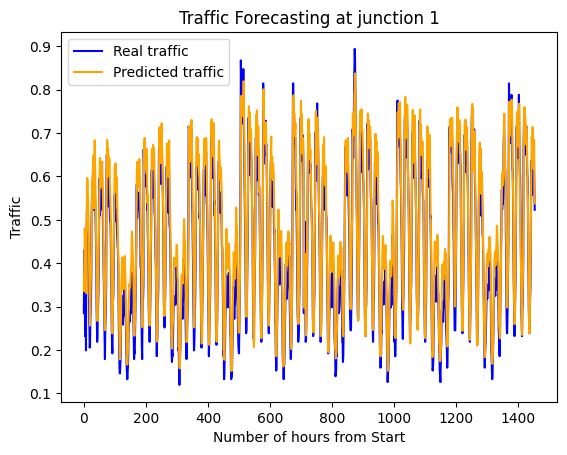

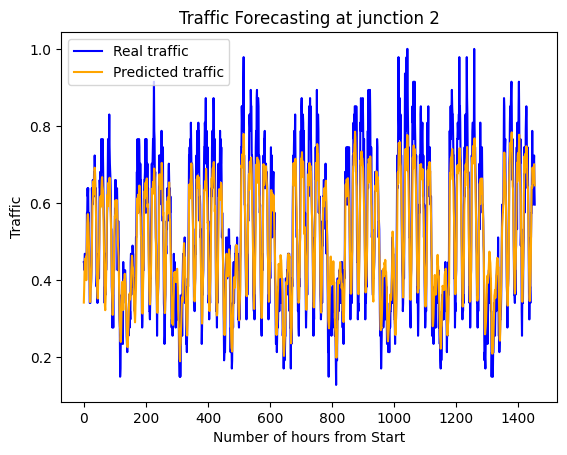

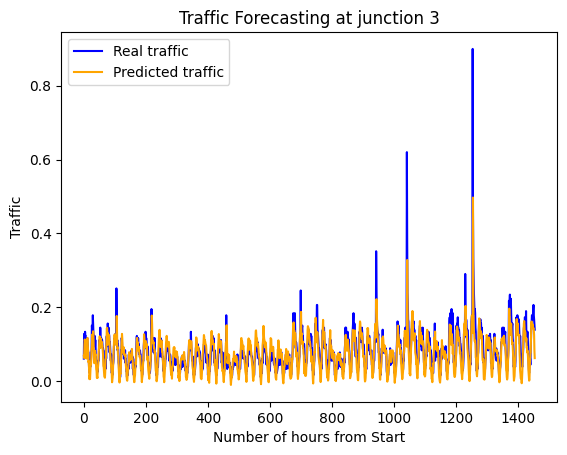

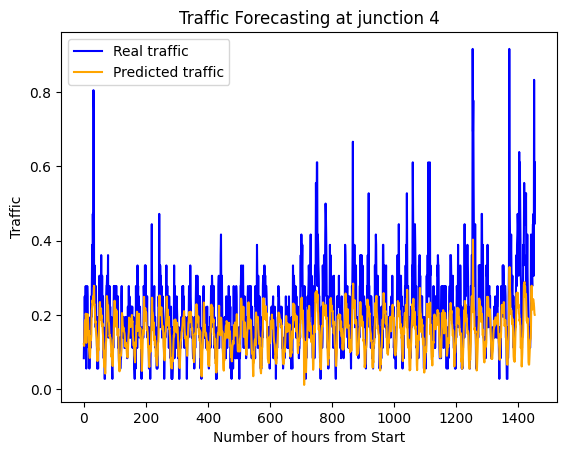

In [40]:
plot_preds(y_test, y_pred)

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [42]:
rmse(y_test, y_pred)

0.07237900242496496

#Validation by feeding predicted values

In [43]:
def pred_seq(model, to_pred, window_size):
    num_preds = to_pred.shape[0]
    current = to_pred[0]
    predicted = []
    for i in range(num_preds):
        predicted.append(model.predict(current[np.newaxis,:,:])[0,:])
        current = current[1:]
        current = np.insert(current, [window_size-1], predicted[-1], axis=0)
    return np.asarray(predicted)

#predictions

In [44]:
set_states(model, RNNs_states)

<ipython-input-33-ea2a3bc56f15>:5: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  for (d,_), s in zip(model.state_updates, states):


In [45]:
seqpreds = pred_seq(model, X_test, seq_len)

1/1 [==============================] - 0s 24ms/step


In [46]:
seqpreds.shape

(1454, 4)

#plot & score

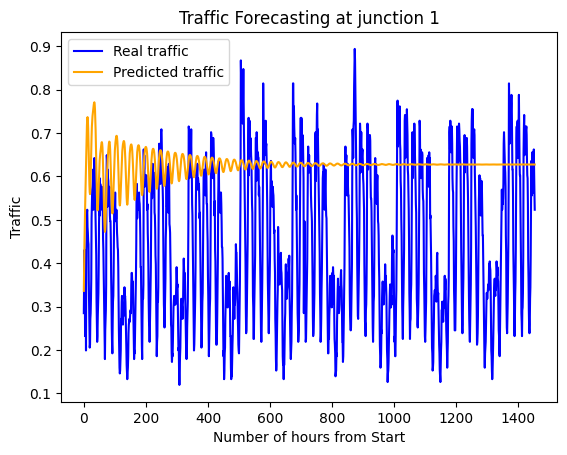

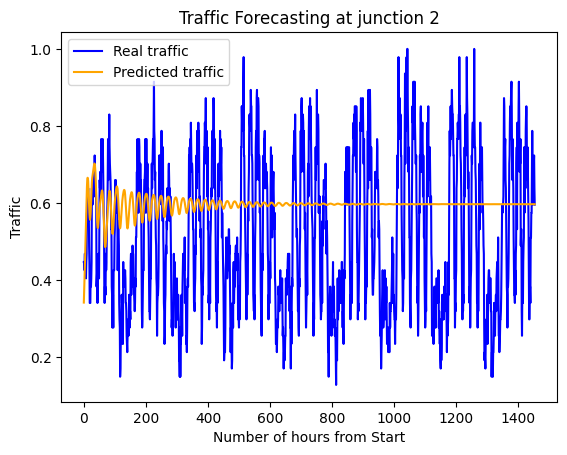

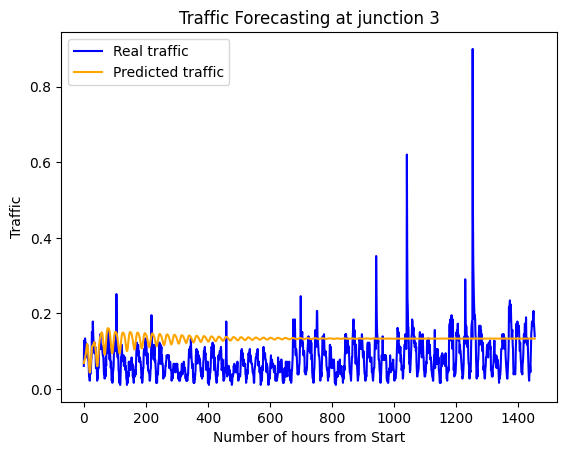

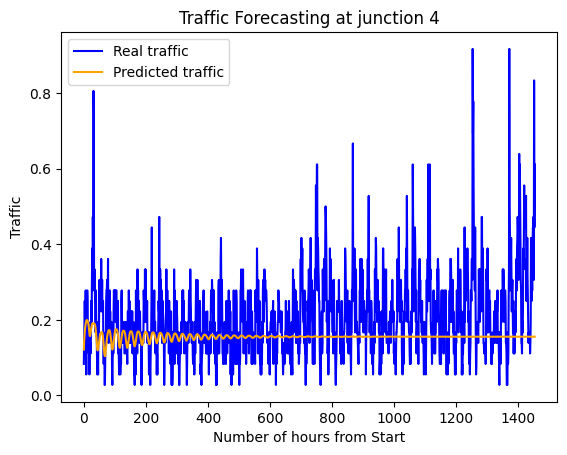

In [47]:
plot_preds(y_test, seqpreds)

In [48]:
rmse(y_test, seqpreds)

0.17645315798085084